# Проект для «Викишоп»

<a id='task'></a>
## Постановка задачи

**Тема проекта:**  разработка модели машинного обучения для поиска токсичных комментариев.

### Назначение

**Цели проекта:** обучить модель классифицировать комментарии на позитивные и негативные.

- постройть модель со значением метрики качества F1 не меньше 0.75. 

### Структура проекта
1. [Постановка задачи][1]
    1. Назначение
    2. Структура проекта
    3. Описание данных
2. [Загрузка и подготовка данных][2]
3. [Лемматизация текста][3]
4. [Обучение моделей][4]
5. [Общие выводы][5]

[1]:#task
[2]:#general
[3]:#lem
[4]:#model
[5]:#fin

### Описание данных

Данные находятся в файле `toxic_comments.csv`.
- Столбец `text` содержит текст комментария.
- `toxic` - целевой признак.

<a id='general'></a>
## Загрузка и подготовка данных

Подготовка к работе с данными: загружаем библиотеки.

In [1]:
import os
import re
import nltk
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

from sklearn.metrics import f1_score

try:
    from imblearn.pipeline import Pipeline 
except:
    !pip install imbalanced-learn
    from imblearn.pipeline import Pipeline 

from sklearn.model_selection import (
    train_test_split, 
    RandomizedSearchCV
)
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer

from nltk.corpus import stopwords as nltk_stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.corpus import wordnet
from nltk import pos_tag
from tqdm.notebook import tqdm  

In [2]:
RANDOM_STATE = 52
TEST_SIZE = 0.25

In [3]:
# подготовка для графиков
palette = ["#F72585", "#4361EE",
           "#b5179e", "#4CC9F0", 
           "#7209B7", "#3A0CA3"]
sns.set(rc={'figure.figsize':(7,5)},
        palette=palette, 
        font_scale=0.95)
sns.set_style(rc = {'axes.facecolor': '#e9e9f0'})

In [4]:
# расширение границ для работы с тетрадкой
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

Считываем датафрейм.

In [5]:
# функция считывания датафрейма
def read_dfs(path, name):
    for i in path:
        if os.path.exists(i+name):
            return pd.read_csv(i+name, index_col=[0], parse_dates=[0])
    return print('File not found')

In [6]:
# записываем возможные пути
paths = ['/datasets/', 
         'https://code.s3.yandex.net/datasets/', 
         'C:\\Users\\Admin\\YandexDisk\\']
# разделение данных
df_name = 'toxic_comments.csv'
comments = read_dfs(paths, df_name)

comments.head(10)

,text,toxic
0,Explanation\nWhy the edits made under my usern...,0
1,D'aww! He matches this background colour I'm s...,0
2,"Hey man, I'm really not trying to edit war. It...",0
3,"""\nMore\nI can't make any real suggestions on ...",0
4,"You, sir, are my hero. Any chance you remember...",0
5,"""\n\nCongratulations from me as well, use the ...",0
6,COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK,1
7,Your vandalism to the Matt Shirvington article...,0
8,Sorry if the word 'nonsense' was offensive to ...,0
9,alignment on this subject and which are contra...,0


In [7]:
comments.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 159292 entries, 0 to 159450
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    159292 non-null  object
 1   toxic   159292 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 3.6+ MB


Пропусков нет. Всего в датафрейме 159 292 записей. Есть пропущенные индексы - исправим, пронумеровав записи по порядку.

In [8]:
comments = comments.reset_index(drop=True)
comments.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159292 entries, 0 to 159291
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    159292 non-null  object
 1   toxic   159292 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 2.4+ MB


Проверим датафрейм на наличие дубликатов.

In [9]:
comments.duplicated().sum()

0

Дубликатов нет.

Проверим баланс классов.

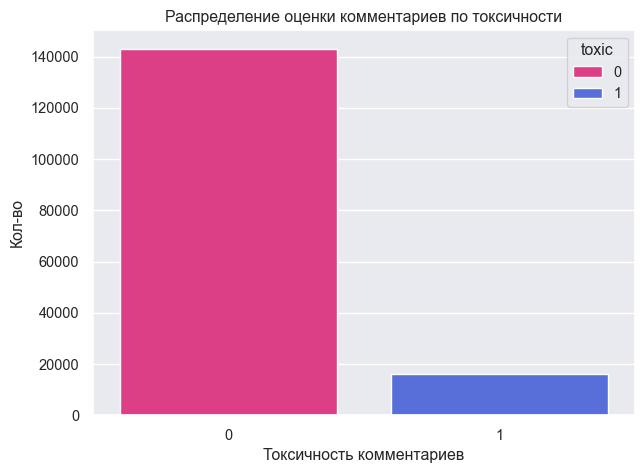

In [10]:
sns.countplot(
    x='toxic',
    data=comments, 
    hue='toxic', 
    dodge=False)
plt.title('Распределение оценки комментариев по токсичности')
plt.ylabel('Кол-во')
plt.xlabel('Токсичность комментариев')

plt.show();

Негативных (оценка `1`) комментариев значительно меньше, чем положительных.

**Вывод:**
- датафрейм содержит 159 292 строк;
- пропусков в данных нет;
- в данных пропущены некоторые индексы, записи пронумерованы по порядку;
- дубликатов нет;
- в данных наблюдается дисбаланс классов целевого признака (перевес класса `0`). Это следует учесть при делении датафрейма на обучающие и тестовые выборки.

<a id='lem'></a>
## Лемматизация текста

In [11]:
# загружаем списки со стоп-словами, пунктуацией и тд.
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
stopwords = set(nltk_stopwords.words('english'))
stopwords = list(stopwords)

lemmatizer = WordNetLemmatizer()

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Admin\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Admin\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Admin\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\Admin\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [12]:
# функция для получения тега-части-речи
def get_pos_tag(tag):
    if tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('N'):
        return wordnet.NOUN
    elif tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

# лемматизация текста
def do_lemm(text):
    # приводим в нижний регистр
    text = text.lower()
    # разбиваем текст на токены
    tokens = word_tokenize(text)
    # получаем тег к каждому токену
    tagged_tokens = pos_tag(tokens)
    
    # приводим слова к лемме
    lemmas = [lemmatizer.lemmatize(
        token, get_pos_tag(tag)) 
              for token, tag in tagged_tokens]
    # объединяем элементы списка в строку
    lemmatized_text = ' '.join(lemmas)
    # очищаем текст
    cleaned_text = re.sub(r'[^a-zA-Z ]', '', lemmatized_text)
    cleaned_text = cleaned_text.replace('\n', '')
    
    return cleaned_text

In [15]:
tqdm.pandas()
comments['lemm_text'] = comments['text'].progress_apply(do_lemm)

  0%|          | 0/159292 [00:00<?, ?it/s]

In [16]:
lemm_df = comments.drop(['text'], axis=1)
lemm_df.head()

,toxic,lemm_text
0,0,explanation why the edits make under my userna...
1,0,daww he match this background colour i m seem...
2,0,hey man i m really not try to edit war it s ...
3,0,more i ca nt make any real suggestion on impr...
4,0,you sir be my hero any chance you remember ...


После очищения и лемматизации текстов еще раз проверим на наличие дубликатов.

In [17]:
lemm_df.duplicated().sum()

650

Избавляемся от дубликатов.

In [18]:
lemm_df = lemm_df.drop_duplicates()
lemm_df.duplicated().sum()

0

**Вывод:** проведена лемматизация, тексты очищены от знаков препинания и стоп-слов, найдены и удалены дубликаты.

<a id='model'></a>
## Обучение моделей

Подготовим данные: разобьем их на выборки.

In [19]:
X = lemm_df['lemm_text']
y = lemm_df['toxic']
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=TEST_SIZE,
    stratify=y,
    random_state=RANDOM_STATE)

X_train.shape, X_test.shape

((118981,), (39661,))

Переведем тексты в векторы.

In [24]:
pipeline = Pipeline(
    [
        ('vect', TfidfVectorizer(stop_words=stopwords)),
        ('models', LogisticRegression(
            solver='liblinear', 
            random_state = RANDOM_STATE)
        ),
    ]
)

Создаем словарь с гиперпараметрами для моделей и обучаем модели.

In [25]:
param_grid = [
    # словарь для модели DecisionTreeClassifier()
   {
       'models': [DecisionTreeClassifier(random_state=RANDOM_STATE)],
       'models__max_depth': range(2, 10)
   },
    # словарь для модели LogisticRegression()
    {
        'models': [LogisticRegression(
            random_state=RANDOM_STATE,
            solver='liblinear'
        )],  
        'models__penalty': ('l1', 'l2'),
        'models__C': list(range(5, 10, 1))
    },
    
]

In [26]:
rs_model = RandomizedSearchCV(
    pipeline,
    param_grid,
    cv = 5,
    n_iter=5,
    scoring = 'f1',
    error_score='raise',
    random_state = RANDOM_STATE,
    n_jobs = -1
)

    
rs_model.fit(X_train, y_train)

print('Модель и лучшие параметры:\n\n', rs_model.best_estimator_)
print ('Метрика F1:', rs_model.best_score_)

Модель и лучшие параметры:

 Pipeline(steps=[('vect',
                 TfidfVectorizer(stop_words=['whom', 'an', 'y', 'by', 'once',
                                             "shan't", 'just', 'they', 'then',
                                             'your', 'his', 'ours', 'will',
                                             'until', 'out', "she's", "won't",
                                             "weren't", 'own', 'hers', 'to',
                                             'ma', "haven't", 'should', 'why',
                                             'yours', 'ain', 'this', 'too',
                                             'because', ...])),
                ('models',
                 LogisticRegression(C=6, penalty='l1', random_state=52,
                                    solver='liblinear'))])
Метрика F1: 0.768479935022879


Лучшая модель - **LogisticRegression** с параметрами `C=6`, `penalty='l1'`. Метрика F1 при кросс-валидации равна 0.77, что соответствует поставленным критериям.

Проверим метрику лучшей модели на тестовой выборке.

In [27]:
preds = rs_model.predict(X_test)
print('Метрика F1:', f1_score(y_test, preds))

Метрика F1: 0.77518327450448


Метрика на тестовой выборке равна 0.78.

Посмотрим на разные пороги.

In [98]:
def get_thresh(THRESHOLD):
    preds = np.where(rs_model.predict_proba(X_test)[:,1] > THRESHOLD, 1, 0)
    f1 = f1_score(y_test, preds)
    print('F1, thresh {}: {}'.format(THRESHOLD, f1))


get_thresh(0.41)
get_thresh(0.61)
get_thresh(0.46)
get_thresh(0.36)

F1, thresh 0.41: 0.7791217459900079
F1, thresh 0.61: 0.7692307692307693
F1, thresh 0.46: 0.7794019042510393
F1, thresh 0.36: 0.7787816210635002


Порог 0.46 улучшает значение метрики на 0.0042 пункта.

<a id='fin'></a>
## Общие выводы

**Цели проекта выполнены:** 
- Загружен датафрейм и выполнена обработка данных.
- Подготовлены выборки для обучения моделей.
- Обучены разные модели и подобраны гиперпараметры.
- Найдена лучшая модель предсказания негативного оттенка комментраиев, метрика F1 которой равна не меньше 0.75.

**Исходные данные:**
Данные из файлеа `toxic_comments.csv`.
- Столбец `text` - текст комментария.
- `toxic` - целевой признак.

**В ходе выполнения работы проделаны следующие шаги:**
- Загружены и проверены соответствия данных в датафреймах;
- Индексы установлены по порядку возрастания без пропусков;
- Проверено наличие дубликатов и пропусков (отсутствуют);
- Проведена лемматизация текста, удалены неинформативные символы;
- Данные разбиты на тренировочную и обучающую выборки;
- Тексты приведены к векторному представлению;
- Обучены модели (`LinearRegression`, `DecisionTree`)
- Найдена лучшая модель:
    - Лучшей моделью является **LinearRegression** с параметрами `C=6`, `penalty='l1'`. Метрика модели соответсвует критериям заказчика (*значение на тестовой выборке F1 не меньше 0.75*) и дает следующие результаты:
        - Метрика **F1** на тренировочной выборке: 0.77
        - Метрика **F1** на тестовой выбборке: 0.78  

[Наверх][1]

[1]:#task